### **Introduction**

**Artificial Intelligence - Internship Project:**

Language Translation (German to English)

**Problem Statement:**

The objective of the project is to implement language
translation model aka machine translation for converting
German to English (and vice versa)

**Dataset Description:**

For this project, the data is a text file (.txt) of English-German sentence
pairs. The actual data contains over 150,000 sentence-pairs.
However, only the first 50,000 sentence
pairs will be used to reduce the training time of the model.


### 1.Import the required libraries

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth',200)

### 2.Function to read the data file
The data is a text file of English-German sentence pairs.

In [2]:
#function to read raw text file
def read_text(filename):
  file = open(filename,mode='rt',encoding='utf-8')
  text = file.read()
  file.close()
  return text

### 3.Function to split the text
The text data is split into English-German pairs separated by '\n'.
These pairs are then split into English and German sentences.

In [3]:
#split the text into sentences
def to_lines(text):
  sent = text.strip().split('\n')
  sent = [i.split('\t') for i in sent]
  return sent

### 4.Reading & preparing the data

In [4]:
data = read_text("/content/Deu_dataset/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [5]:
print(deu_eng)

[['Go.' 'Geh.'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)']
 ['Hi.' 'Hallo!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)']
 ['Hi.' 'Grüß Gott!'
  'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)']
 ...
 ['It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages rather than experiment in languages they are learning, we might be able to minimize errors.'
  'Es ist wohl unmöglich, einen vollkommen fehlerfreien Korpus zu erreichen\xa0— das liegt in der Natur eines solchen Gemeinschaftsprojekts. Doch wenn wir unsere Mitglieder dazu bringen können, nicht mit Sprachen herumzuexperimentieren, die sie gerade lernen, sondern Sätze in ihrer eigenen Muttersprache beizutragen, dann gelingt es uns vielleicht, die Zahl der Fehler klein zu halten.'
  'CC-BY

The actual data contains over 150,000 sentence pairs. But only the first 50,000 sentence pairs will be used in order to reduce the training time of the model.

In [6]:
deu_eng = deu_eng[:50000,:]

In [7]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Tom is still sitting.', 'Tom sitzt noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2273521 (CK) & #10190706 (wolfgangth)'],
       ['Tom is still smoking.', 'Tom raucht immer noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646953 (CK) & #8072723 (Luiaard)'],
       ['Tom is still talking.', 'Tom spricht noch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2646952 (CK) & #10150806 (wolfgangth)']],
      dtype='<U537')

### 5.Text to Sequence Conversion
The input and output sentences need to be converted into integer sequences of fixed length, so that it can be fed to Seq2Seq model. Two histograms are used to visualize the length of the sentences. The lengths of all the sentences are captured in two separate lists for English and German respectively.

In [8]:
#empty lists
eng_l = []
deu_l = []

#populate the lists with sentence lengths
for i in deu_eng[:,0]:
  eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
  deu_l.append(len(i.split()))

In [9]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

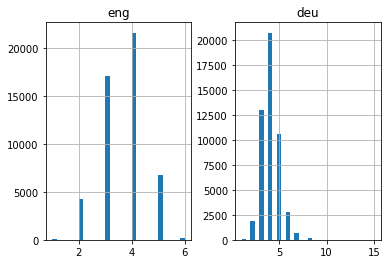

In [10]:
length_df.hist(bins = 30)
plt.show()

From the visualization, it can be seen that the maximum length of German sentences is 11 and that of English sentences is 8.

#### 5.1.Function to vectorize the text data 
The text data is vectorized by using keras Tokenizer() class. This will turn the sentences into sequence of integers. Both the English and German sentences are vectorized.

In [11]:
#function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [12]:
#prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:,0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6123


In [13]:
#prepare deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:,1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1
deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10087


#### 5.2.Function to pad the sequences
The vectorized sequences will be padded with zeroes upto the maximum sequence length so that all the sequences are of the same length.

In [14]:
#encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  seq = tokenizer.texts_to_sequences(lines)
  seq = pad_sequences(seq, maxlen = length, padding = 'post')
  return seq

### 6.Building the model
The data is split into traininig and testing set for model training and evaluation.

In [15]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size = 0.2, random_state = 12)

#### 6.1.Encoding the sentences
The German sentences are encoded as the input and English sentences as the target sequences.

In [16]:
#prepare training data
train_x = encode_sequences(deu_tokenizer, deu_length, train[:,1])
train_y = encode_sequences(eng_tokenizer, eng_length, train[:,0])

In [17]:
#prepare validation data
test_x = encode_sequences(deu_tokenizer, deu_length, test[:,1])
test_y = encode_sequences(eng_tokenizer, eng_length, test[:,0])

#### 6.2.Seq2Seq Model
An Embedding layer and an LSTM layer are used as the encoder and another LSTM layer followed by a Dense layer are used as the decoder.

In [18]:
#build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length= in_timesteps, mask_zero = True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences= True))
  model.add(Dense(out_vocab, activation = 'softmax'))
  return model

RMSprop optimizer is used in this model as it is considered a good choice for Recurrent Neural Networks.

In [19]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = rms, loss = 'sparse_categorical_crossentropy')

### 7.Training the model
The model will be trained for 5 epochs and with a batch size of 512. The ModelCheckpoint() function is used to save the best model with lowest validation loss.

In [20]:
filename = 'model1'
checkpoint = ModelCheckpoint(filename, monitor = 'val_loss', verbose=1, save_best_only = True, mode='min')
history = model.fit(train_x, train_y.reshape(train_y.shape[0], train_y.shape[1], 1),
                    epochs=5, batch_size =512, 
                    validation_split=0.2, 
                    callbacks = [checkpoint], verbose=1)

Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 3.3290
Epoch 00001: val_loss improved from inf to 2.97135, saving model to model1


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 276s 4s/step - loss: 3.3290 - val_loss: 2.9713
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 2.6989
Epoch 00002: val_loss improved from 2.97135 to 2.67198, saving model to model1


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 263s 4s/step - loss: 2.6989 - val_loss: 2.6720
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 2.5272
Epoch 00003: val_loss improved from 2.67198 to 2.48210, saving model to model1


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 266s 4s/step - loss: 2.5272 - val_loss: 2.4821
Epoch 4/5
63/63 [==============================] - ETA: 0s - loss: 2.3642
Epoch 00004: val_loss improved from 2.48210 to 2.35725, saving model to model1


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 262s 4s/step - loss: 2.3642 - val_loss: 2.3572
Epoch 5/5
63/63 [==============================] - ETA: 0s - loss: 2.2129
Epoch 00005: val_loss improved from 2.35725 to 2.24480, saving model to model1


INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 264s 4s/step - loss: 2.2129 - val_loss: 2.2448


Comparison of the training loss and validation loss using a visualization.

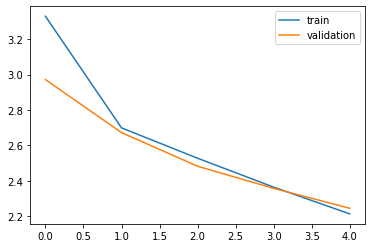

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### 8.Testing the model

In [22]:
model = load_model('model1')
pred = model.predict(test_x.reshape((test_x.shape[0],test_x.shape[1])))

In [23]:
pred = argmax(pred,axis=1)

In [24]:
pred

array([[7, 0, 0, ..., 2, 2, 2],
       [7, 0, 0, ..., 2, 2, 2],
       [7, 0, 0, ..., 2, 2, 2],
       ...,
       [7, 2, 0, ..., 0, 0, 0],
       [7, 2, 0, ..., 1, 2, 2],
       [7, 2, 0, ..., 2, 3, 3]])

In [25]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [ ]:
#convert predictions into text in English
pred_text = []
for i in pred:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j>0:
      if(t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)
pred_text.append(''.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual':test[:,0],'predicted':pred_text})

In [ ]:
pd.set_option('display.max_colwidth',200)

In [ ]:
pred_df.head(15)

In [ ]:
pred_df.tail(15)